In [41]:
%matplotlib inline

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import librosa
import librosa.display

In [42]:
import tarfile
import re
import io
    
def load_dataset(tarpath, labelpath, limit=None):
    labels = pandas.read_csv(labelpath, index_col='itemid')
    dataset = []
    labeldata = []
    
    with tarfile.open(tarpath, mode="r|gz") as tar:
        regex = r".*\/(\d+)\..*"
        for i, member in enumerate(tar):
            if limit is not None:
                if i >= limit:
                    break

            sample = int(re.findall(regex, member.name)[0])
            content = tar.extractfile(member).read()
            data = pandas.read_csv(io.BytesIO(content), encoding='utf8')

            #features = features_from_mfcc(data)
            features = data
            hasbird = labels.hasbird[sample].astype('bool')
            dataset.append(features)
            labeldata.append(hasbird)
        
    return dataset, labeldata


In [44]:
dataset = load_dataset('data/ff1010bird.mfcc.tgz', 'data/ff1010bird.labels.csv', limit=5000)

In [9]:
def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()

def plot_spectrogram(S, title='Mel spectrogram', fmax=8000):
    plt.figure(figsize=(10, 4))
    d = librosa.power_to_db(S, ref=numpy.max)
    librosa.display.specshow(d, y_axis='mel', x_axis='time', fmin=500, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

#print(X[1].T.shape)
#print(numpy.mean(X[1].T, axis=1).shape)

#plot_mfcc(X[1].T)
#plot_mfcc(meansub(X[1].T))

In [12]:
def plot_precision_recall(Y_test, Y_score):
    average_precision = metrics.average_precision_score(Y_test, Y_score)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, Y_score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [54]:
from scipy import ndimage

def meansub(s):
    return s - (numpy.mean(s, axis=0) + 1e-8)

def features_from_mfcc(stored):
    mfcc = stored.T
    mfcc = meansub(mfcc)
    #mfcc = mfcc / numpy.sum(mfcc)
    filt = ndimage.median_filter(mfcc, (1, 1))
    
    delta = librosa.feature.delta(mfcc, width=9, order=1)
    
    features = numpy.concatenate([
        #numpy.mean(mfcc, axis=1),
        #numpy.std(mfcc, axis=1),
        numpy.min(filt, axis=1),
        numpy.max(filt, axis=1),
        #numpy.min(delta, axis=1),
        #numpy.max(delta, axis=1),
    ])
    
    return features

def get_features(dataset):
    data, labels = dataset
    features = [features_from_mfcc(m) for m in data]
    return numpy.array(features), numpy.array(labels)

X, Y = get_features(dataset)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
X.shape, Y.shape, numpy.mean(Y)

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=1),
)

scores = model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=5)
print('cv: {:.4f} {:.4f} ||'.format(numpy.mean(scores), numpy.std(scores)), scores)
rf.fit(X_train, Y_train)
roc_auc = metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1])
Y_pred = rf.predict(X_test)
recall = metrics.recall_score(Y_test, Y_pred)
print('ROC AUC', roc_auc)
print('recall', recall)

metrics.confusion_matrix(Y_test, Y_pred)

cv: 0.7602 0.0212 || [0.73961802 0.79437405 0.7559873  0.73829817 0.77250687]
ROC AUC 0.7497898481207436
recall 0.39037433155080214


array([[1069,   57],
       [ 228,  146]])

In [51]:
cf = metrics.confusion_matrix(Y_test, Y_pred)
cf / cf.sum(axis=0)

array([[0.81450382, 0.31052632],
       [0.18549618, 0.68947368]])

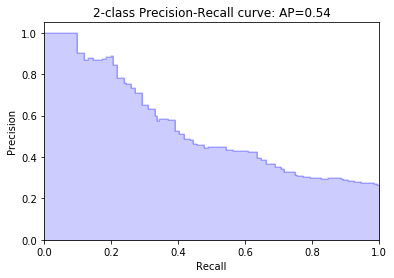

In [13]:
plot_precision_recall(Y_test, rf.predict_proba(X_test)[:,1])

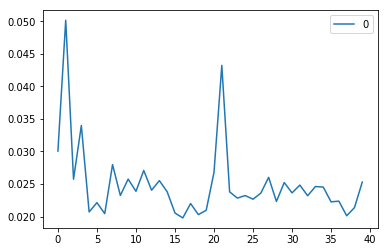

In [125]:
pandas.DataFrame(rf.steps[1][1].feature_importances_).plot()